<a href="https://colab.research.google.com/github/carloslme/tv_program_info/blob/main/binary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUMMARY
This Notebook contains a general architecture, model architecture (training and validation), image preprocessing and OCR engine to extract information from TV images only if the model considers that the input image has info about the program.

There are to classes: grid and show. 
* grid class contains a 


To classify the images, a Convolutional Neural Network is used not only because its high accuracy but the next reasons:
* A CNN has a incredible ability to detect patterns in data. For this exercise, the first class called "grid" has an specific gray rectangle that even having different info about the program such as time, channel, program description and so on, the rectangle is the pattern to look it for. 
* To use another classification algorithm like SVM or KNN, an extraction and normalization of image features is required. The nature of this exercise, which contains a large type of different images, makes it difficult to train the models with other classification algorithms.
* Another approach that could be used in the future is to use Object Detection to at least extract the channel/tv-shows if it is present in the input image, based on some trained model with channel/tv-shows logos.



## Requirements
[SPANISH]
* El ejercicio consiste en construir y entrenar un modelo que clasifique imágenes de TV de acuerdo a si la imagen contiene información sobre el programa. 
* Este modelo debe ser capaz de generalizar a los casos que no aparecen en el conjunto de entrenamiento. Describir los falsos positivos y (si los hay) posibles falsos negativos.
Suponiendo que ya clasificaste una imagen como imagen que contiene información de un programa, describe qué métodos usarías para obtener la información del programa por categorías (nombre, hora, canal, etc) a partir de la misma imagen. No es necesario implementar esta parte del ejercicio
* Describir la arquitectura del modelo usado y por qué se eligió dicha arquitectura y entregar el modelo y cualquier asset necesario en un zip, además del código correspondiente. Puedes entregarlo en un Jupyter Notebook.

## Architecture flow
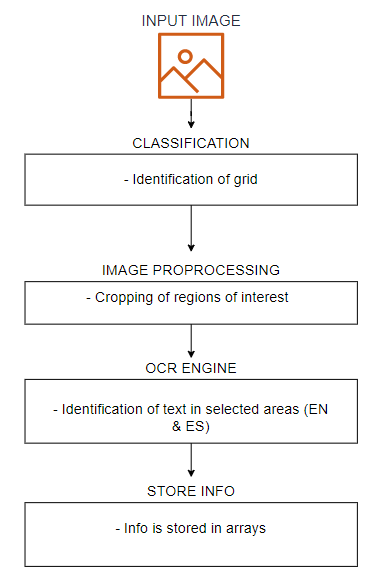

# CLASSIFICATION
In this section, the model is trained and validated. 

## Import libraries



In [3]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob

## Loading data


In [4]:
base_dir = '/content/drive/My Drive/Colab Notebooks/imagenes'
base_dir_test = '/content/drive/My Drive/Colab Notebooks/test'
list_grid = glob.glob(base_dir+'/grid/*.*')
list_show = glob.glob(base_dir+'/show/*.*')
list_test = glob.glob(base_dir_test+'/grid/*.*')
print(len(list_grid))
print(len(list_show))
print(len(list_test))

500
500
63


### Exploring data

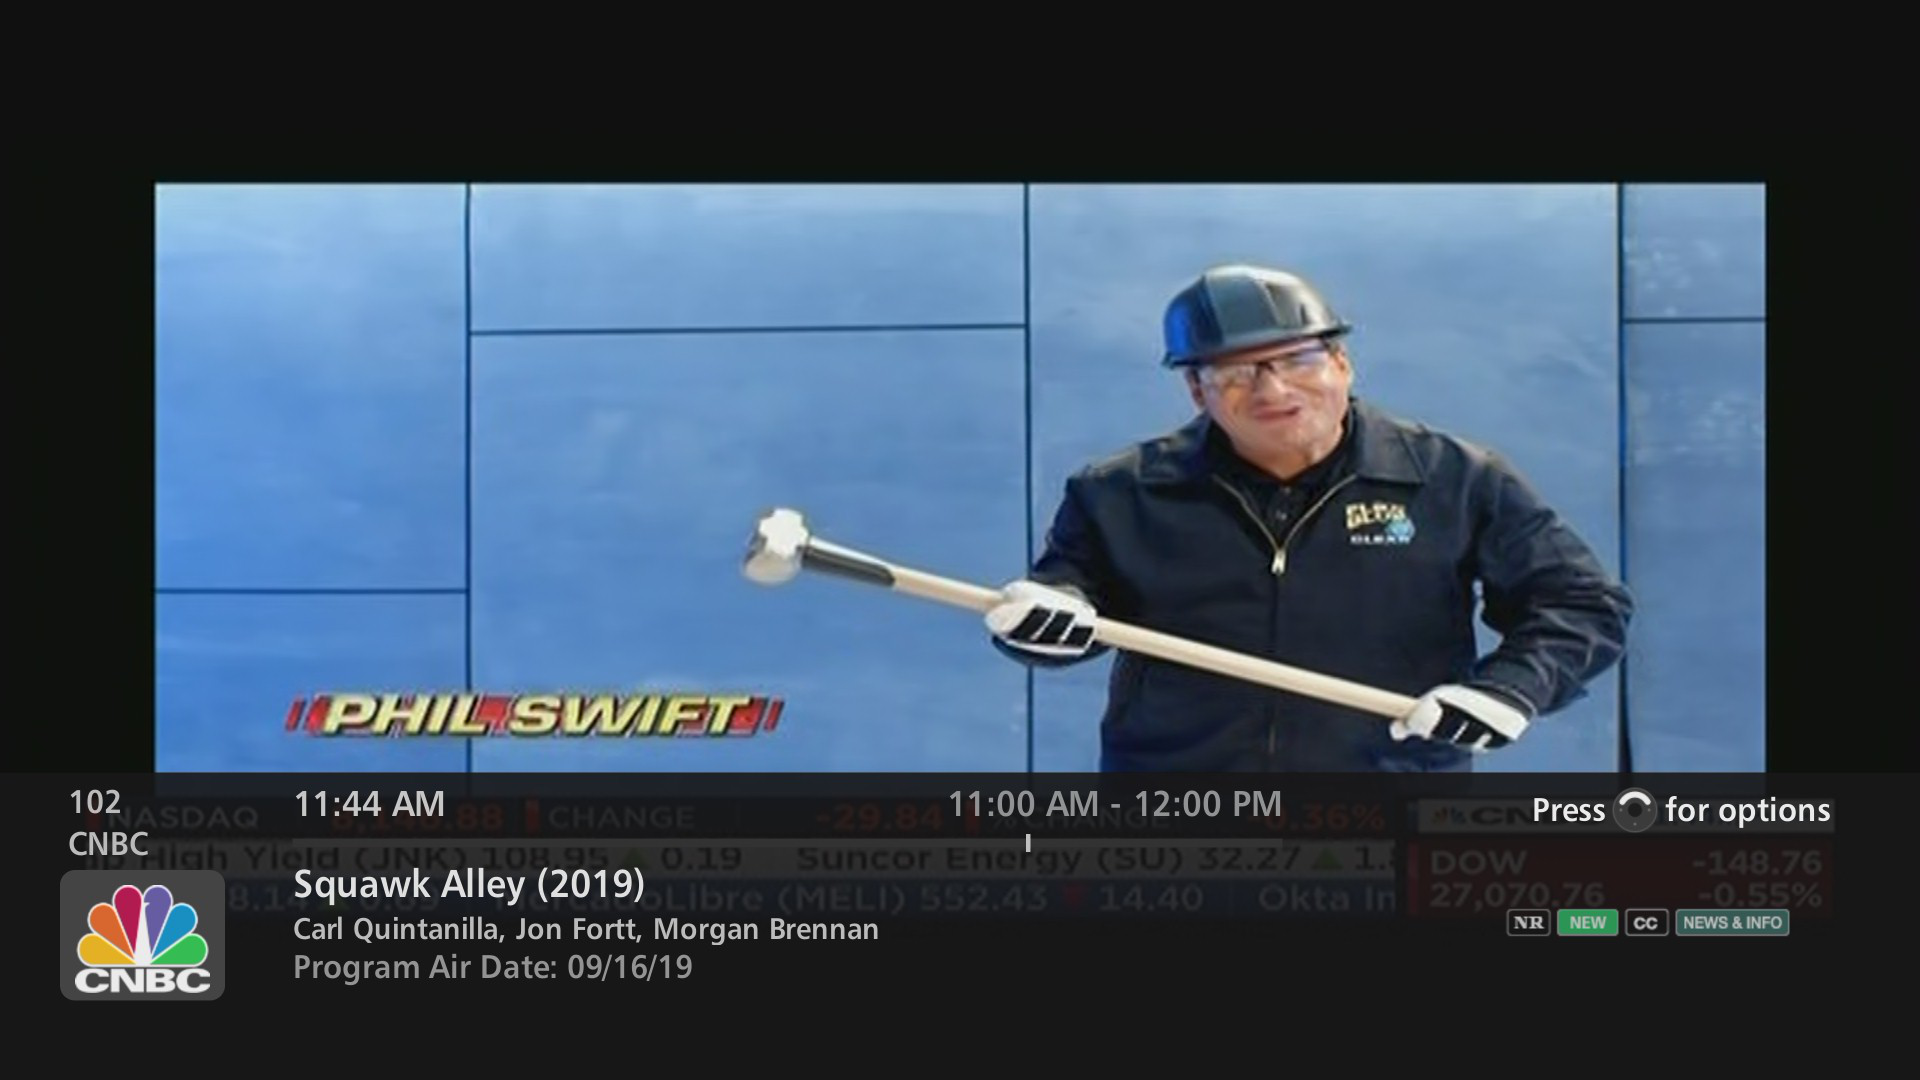

In [ ]:
img_temp_grid = PIL.Image.open(str(list_grid[1]))
np.asarray(img_temp_grid).shape
PIL.Image.open(str(list_grid[1]))

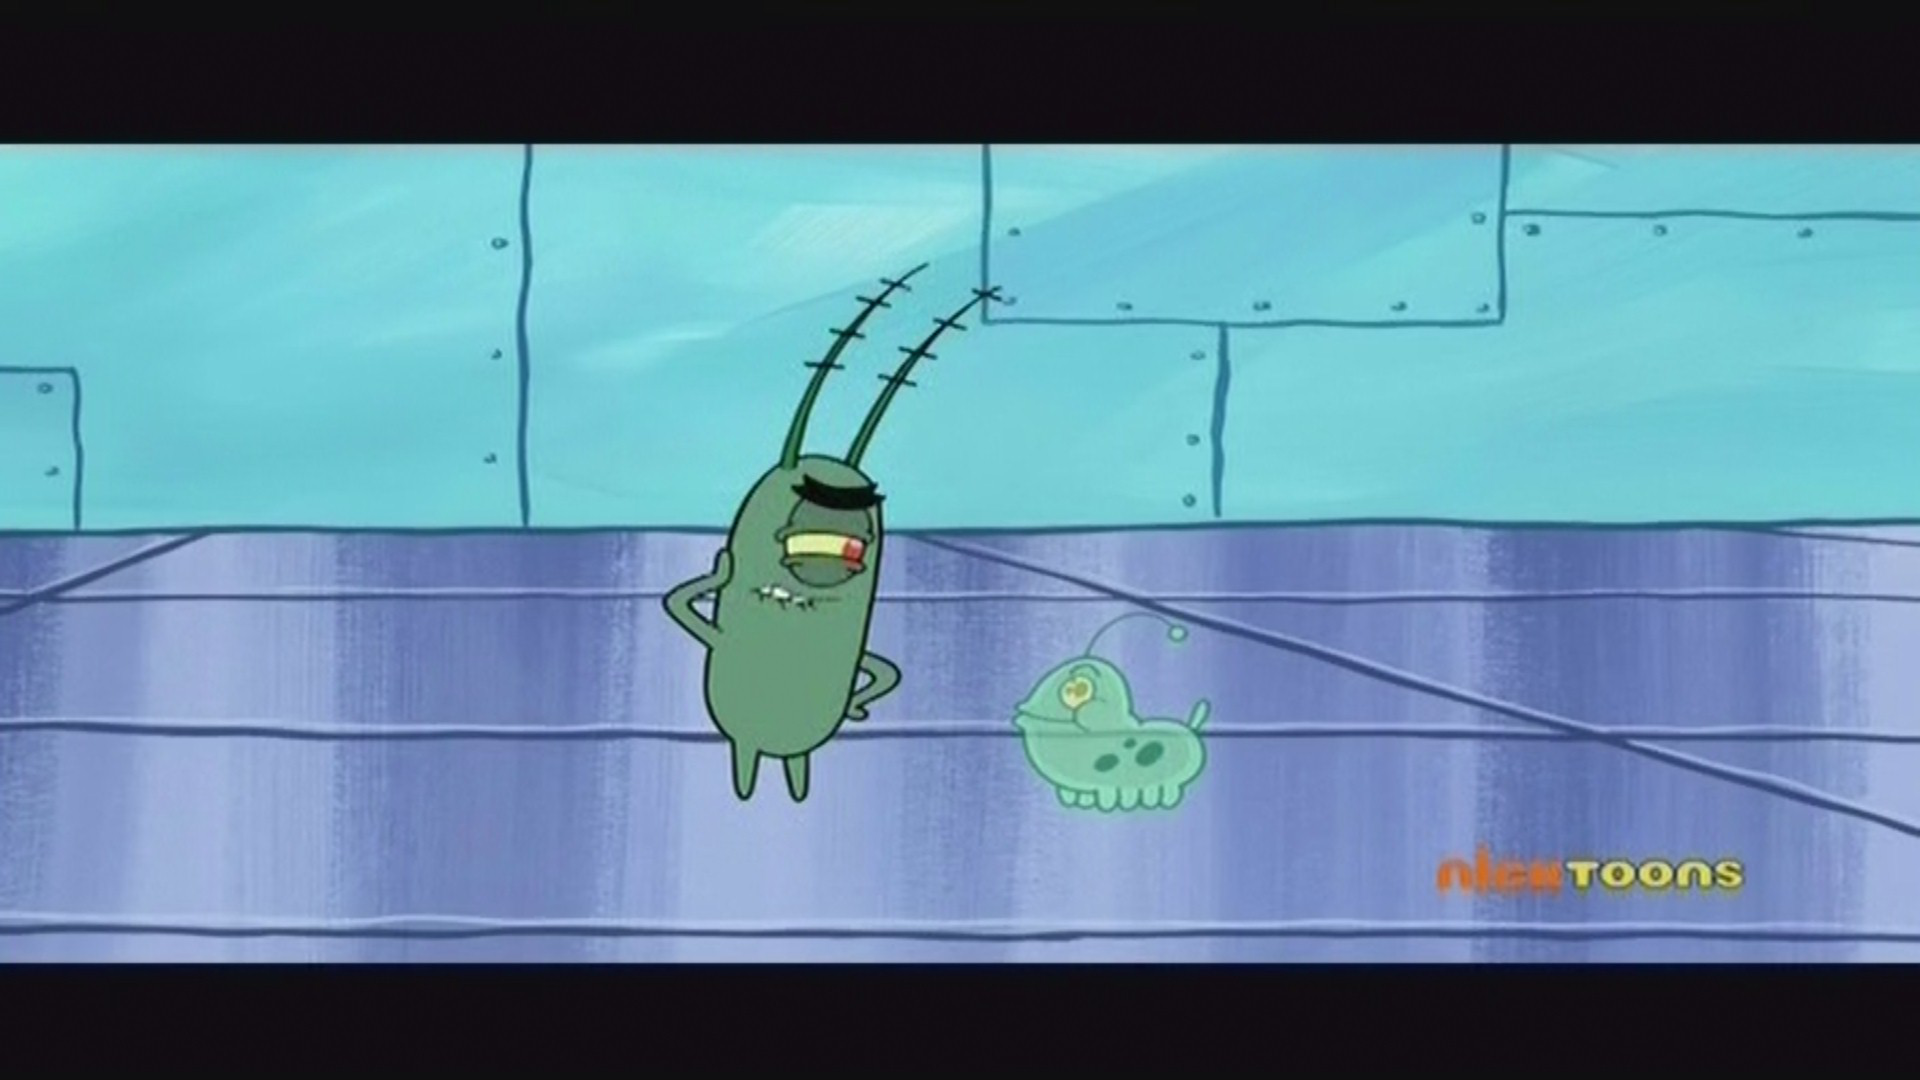

In [ ]:
img_temp_show = PIL.Image.open(str(list_show[1]))
np.asarray(img_temp_show).shape
PIL.Image.open(str(list_show[1]))

### Loading data using keras.preprocessing

#### Create a dataset
1000 images for training and testing
- grid: 400 images (80%) for training, 100 images (20%) for testing
- show: 400 images (80%) for training, 100 images (20%) for testing

121 images separated never used neither training nor testing (simulate "real-world" data)
- grid: 63 images
- show: 58 images


In [ ]:
batch_size = 32
img_height = 256
img_width = 256

Training data

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.
Using 800 files for training.


Validation data

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.
Using 200 files for validation.


Test data ("real-world" data)

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir_test, 
  subset="validation",
  seed=123,
  validation_split=0.9,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

Found 121 files belonging to 2 classes.
Using 108 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['grid', 'show']


#### Visualize the training data

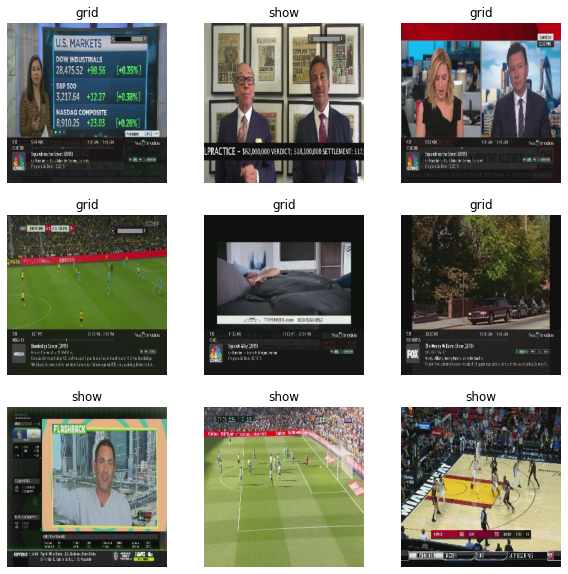

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

To ensure that the dataset does not become a bottleneck while training the model due to any kind of I/O disk blocking, the .cache() and .prefetch() methods are used.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # keeps the images in memory after they're loaded off disk during the first epoch.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # This allows subsequent items to be prepared while the current item is being processed.

### Standardize the data
Adding a **Rescaling layer** to convert RGB channes values from [0, 255] to [0, 1], ideal for neural network.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9733916


## Create the convolutional base and Dense layers
The model consists of 3 convolutional blocks, a dropout layer and a max pool in each of them. Each Conv2D one has the next parameters overall:
  * 16, 32 64 and 128 filters, then these are used by Max pooling to reduce the spatial dimensiones of the output volume
  * kernel_size = 5, it means size > 3 due to input images are greater than 128x128
  * kernel_initializer = "glorot_uniform", controls the initialization method used to initialize all values in the Conv2D class prior to actually training the network, "glorot_uniform" is used because is perfectly fine for the majority of tasks
  * kernel_regularizer=ls(0.005), to apply regularization and reduce the effects of overfitting and increase the ability of the model to generalize
  * activation='relu' in three hidden layers, ReLU is important because it does not saturate; the gradient is always high (equal to 1) if the neuron activates. 

After each Conv2D, a Dropout layer is added to help the network generalize and not overfit. Neurons from the current layer, with probability p, will randomly disconnect from neurons in the next layer so that the network has to rely on the existing connections.


In [ ]:
num_classes = 2
kernel = 5 # Due to input images are greater than 128x128, the kernel size is > 3
init = "glorot_uniform"
reg = l2(0.0005) # L2 regularization to detect signs of overfitting

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, kernel_size=kernel, padding='same', kernel_initializer=init, kernel_regularizer=reg, activation='relu'), # "same" to to reduce spatial dimensiones of the volume by Maxpooling
  layers.Dropout(0.25),
  layers.MaxPooling2D(pool_size=(2,2)), # 2x2 filter of max pooling
  layers.Conv2D(32, kernel_size=kernel, padding='same', kernel_initializer=init, kernel_regularizer=reg, activation='relu'),
  layers.Dropout(0.25),
  layers.MaxPooling2D(pool_size=(2,2)), # 2x2 filter of max pooling
  layers.Conv2D(64, kernel_size=kernel, padding='same', kernel_initializer=init, kernel_regularizer=reg, activation='relu'),
  layers.Dropout(0.25),
  layers.MaxPooling2D(pool_size=(2,2)), # 2x2 filter of max pooling
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(units=1, activation="sigmoid") # use of 'sigmoid' because of the number of classes=2
])

## Compile and train de model

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      12832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)       

## CNN model architecture
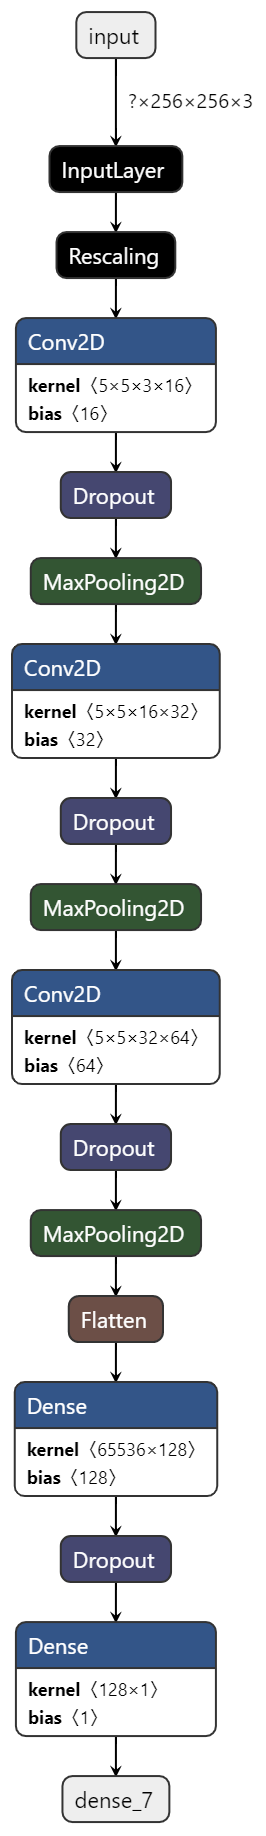

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
25/25 [==============================] - 260s 10s/step - loss: 0.2344 - accuracy: 0.9187 - val_loss: 0.0445 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 108s 4s/step - loss: 0.0425 - accuracy: 0.9975 - val_loss: 0.0356 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 107s 4s/step - loss: 0.0352 - accuracy: 0.9987 - val_loss: 0.0335 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 107s 4s/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 112s 4s/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 0.0306 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 107s 4s/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 107s 4s/step - loss: 0.0286 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 1.0000
Epoch 8/10
2

## Visualize training results

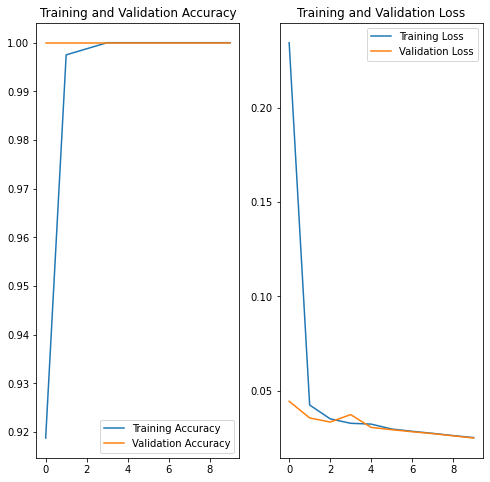

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## The Accuracy, ROC Curve, and AUC

Evaluate the accuracy of the model:

In [ ]:
model.evaluate(val_ds)

7/7 [==============================] - 5s 781ms/step - loss: 0.0250 - accuracy: 1.0000


[0.025003008544445038, 1.0]

Calculating ROC curve and plot it

In [ ]:
STEP_SIZE_TEST=val_ds./val_ds.batch_size
model.evaluate_generator(val_ds)
preds = model.predict(val_ds,verbose=1)

7/7 [==============================] - 5s 776ms/step


array([[8.73084218e-07],
       [8.12714643e-06],
       [3.63529665e-07],
       [9.99999166e-01],
       [1.17716404e-07],
       [9.99819398e-01],
       [9.99997377e-01],
       [9.99998331e-01],
       [7.66228768e-05],
       [1.57517377e-06],
       [9.99999285e-01],
       [9.99929965e-01],
       [3.13180344e-08],
       [9.99999225e-01],
       [1.76721002e-07],
       [9.99981046e-01],
       [9.97263789e-01],
       [5.41813620e-07],
       [9.99999523e-01],
       [6.27581358e-06],
       [5.13664702e-07],
       [1.10978237e-06],
       [7.31457817e-07],
       [2.35828520e-06],
       [1.59190483e-06],
       [3.09069173e-06],
       [4.80037943e-06],
       [3.67209907e-07],
       [4.88225123e-06],
       [9.99644876e-01],
       [2.06593700e-06],
       [7.19873512e-08],
       [5.89385252e-07],
       [2.43695854e-06],
       [9.99589562e-01],
       [6.23067876e-07],
       [1.00000000e+00],
       [9.18716239e-07],
       [9.99868870e-01],
       [1.63290025e-07],


In [ ]:
y = np.concatenate([y for x, y in val_ds], axis=0)
y

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1], dtype=int32)

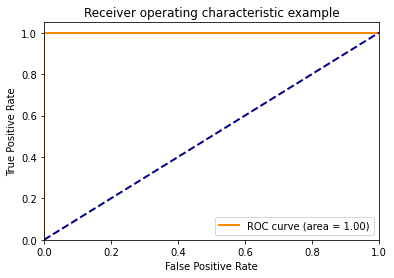

In [ ]:
from sklearn.metrics import roc_curve, auc
classes = ['grid','show']

fpr, tpr, _ = roc_curve(y, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The ROC curve for this model shows a perfect classification over the validation data. 

## False positives and false negatives
* **False positive**: to describe these ones, it's considered that the case is FP when the image is classified as "grid" and has text that not correspond program information. For example: images with info in the background or ads.
* **False negative**: to describe an image that is classified as "show", but actually has information about the program.

# IMAGE PREPROCESSING
If the image is classified as "grid" class, one alternative to extract the information is to apply an OCR engine over specific ROIs. 
For this module, the ROIs are implemented as follows:

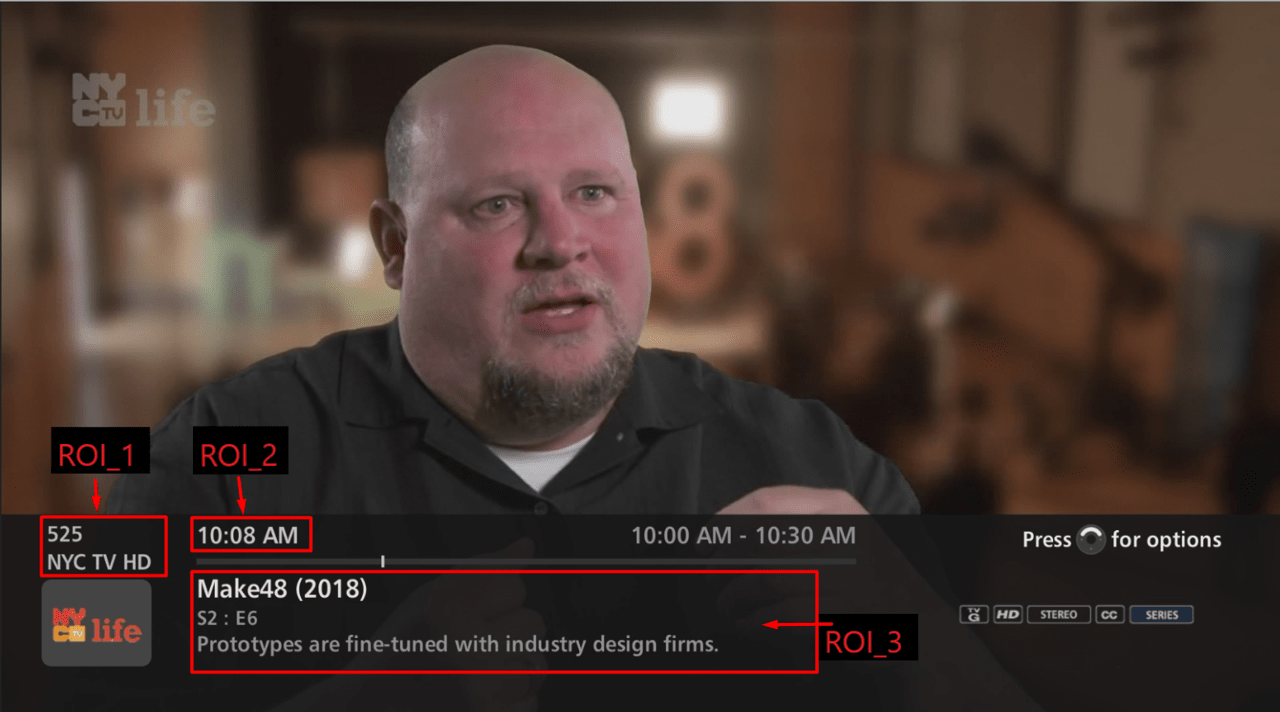

Where **ROI_1** is the channel and program, **ROI_2** the time and **ROI_3** the description.


In [38]:
def get_rois(img):
  # (x,y)
  top_left_1 = (60,775)
  bottom_right_1 = (280,860)
  
  top_left_2 = (285,775)
  bottom_right_2 = (450,830)
  
  top_left_3 = (280,860)
  bottom_right_3 = (1450,1050)

  # img[y1:u2, x1:x2]
  roi_1 = img[775:860, 60:280]
  roi_2 = img[775:830, 285:450]
  roi_3 = img[860:1050, 280:1450]

  return roi_1, roi_2, roi_3

## Getting ROIs

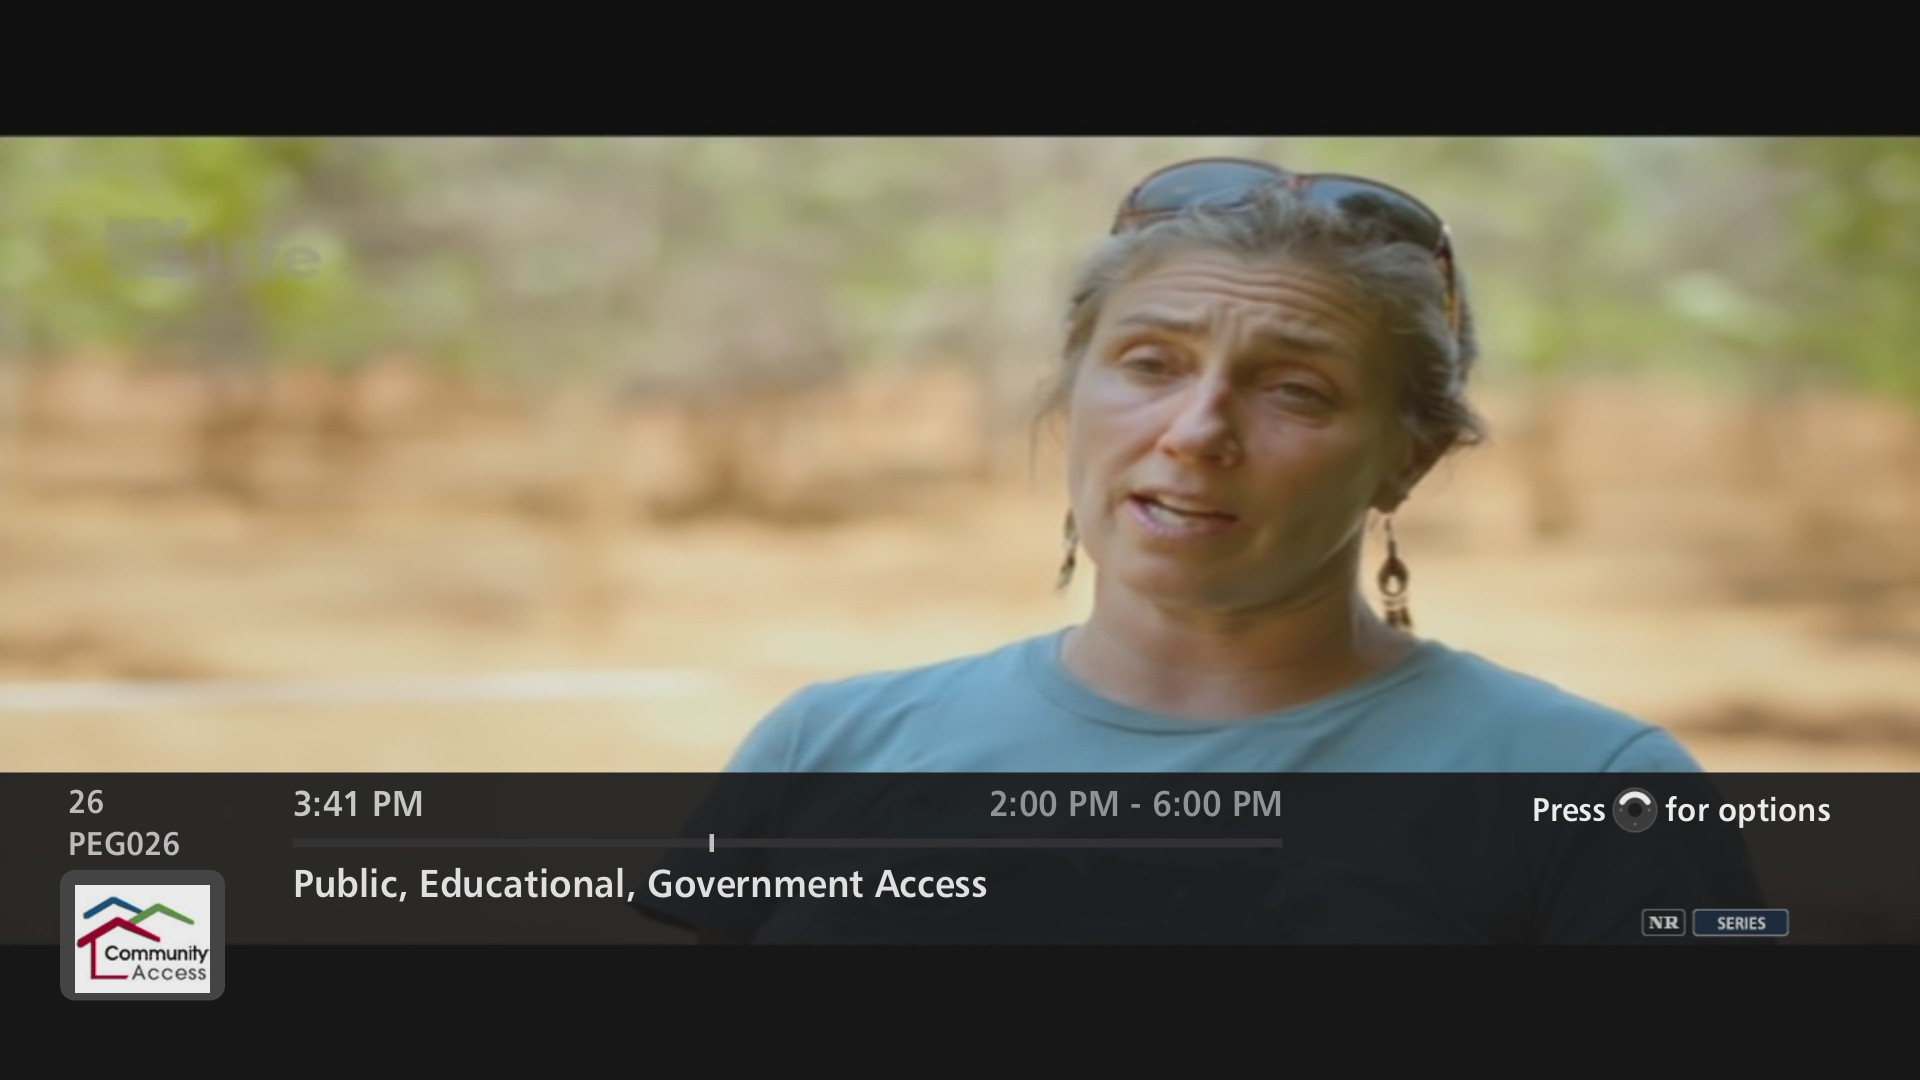

In [41]:
img_test = cv2.imread(list_test[3])
cv2_imshow(img_test)

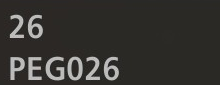

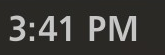

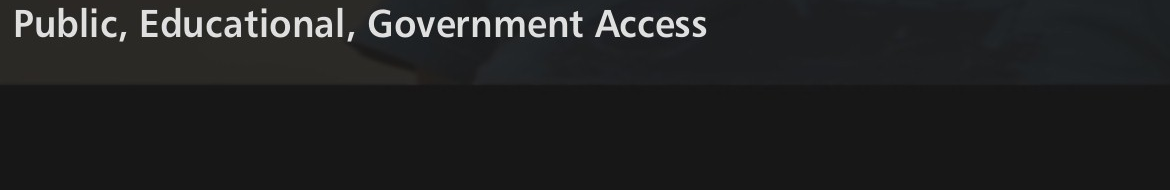

In [42]:
from google.colab.patches import cv2_imshow

roi_1, roi_2, roi_3 = get_rois(img_test)
cv2_imshow(roi_1)
cv2_imshow(roi_2)
cv2_imshow(roi_3)

# OCR ENGINE
For this exercise, the EASY OCR library is used. It's quite simple to implement and is open source

In [44]:
!pip install easyocr

     |████████████████████████████████| 48.9MB 81kB/s 


In [47]:
import easyocr

# OCR the input image using EasyOCR
print("[INFO] OCR'ing input image...")
langs = ['es','en']
reader = easyocr.Reader(langs, gpu=-1)
results_channel = reader.readtext(roi_1)
results_time = reader.readtext(roi_2)
results_description = reader.readtext(roi_3)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...


In [48]:
def cleanup_text(text):
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV
	return "".join([c if ord(c) < 128 else "" for c in text]).strip()

[INFO] 0.5219: 26
[INFO] 0.5736: PEG026


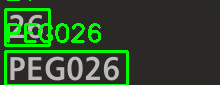

In [49]:
# loop over the results
for (bbox, text, prob) in results_channel:
	# display the OCR'd text and associated probability
	print("[INFO] {:.4f}: {}".format(prob, text))
	# unpack the bounding box
	(tl, tr, br, bl) = bbox
	tl = (int(tl[0]), int(tl[1]))
	tr = (int(tr[0]), int(tr[1]))
	br = (int(br[0]), int(br[1]))
	bl = (int(bl[0]), int(bl[1]))
	# cleanup the text and draw the box surrounding the text along
	# with the OCR'd text itself
	text = cleanup_text(text)
	cv2.rectangle(roi_1, tl, br, (0, 255, 0), 2)
	cv2.putText(roi_1, text, (tl[0], tl[1] - 10),
	cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
 
 # show the output image
cv2_imshow(roi_1)

[INFO] 0.4121: 3:41 PM


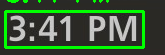

In [50]:
# loop over the results
for (bbox, text, prob) in results_time:
	# display the OCR'd text and associated probability
	print("[INFO] {:.4f}: {}".format(prob, text))
	# unpack the bounding box
	(tl, tr, br, bl) = bbox
	tl = (int(tl[0]), int(tl[1]))
	tr = (int(tr[0]), int(tr[1]))
	br = (int(br[0]), int(br[1]))
	bl = (int(bl[0]), int(bl[1]))
	# cleanup the text and draw the box surrounding the text along
	# with the OCR'd text itself
	text = cleanup_text(text)
	cv2.rectangle(roi_2, tl, br, (0, 255, 0), 2)
	cv2.putText(roi_2, text, (tl[0], tl[1] - 10),
	cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
 
 # show the output image
cv2_imshow(roi_2)

[INFO] 0.2579: Public, Educational, Government Access


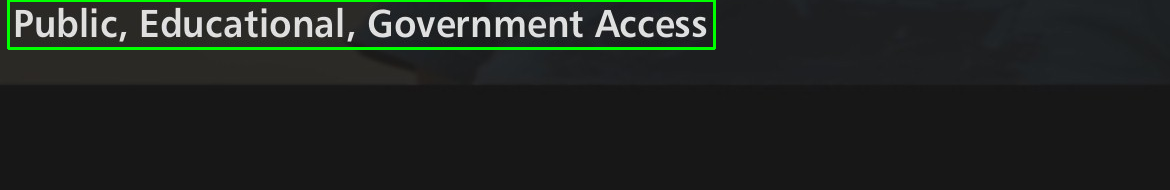

In [51]:
# loop over the results
for (bbox, text, prob) in results_description:
	# display the OCR'd text and associated probability
	print("[INFO] {:.4f}: {}".format(prob, text))
	# unpack the bounding box
	(tl, tr, br, bl) = bbox
	tl = (int(tl[0]), int(tl[1]))
	tr = (int(tr[0]), int(tr[1]))
	br = (int(br[0]), int(br[1]))
	bl = (int(bl[0]), int(bl[1]))
	# cleanup the text and draw the box surrounding the text along
	# with the OCR'd text itself
	text = cleanup_text(text)
	cv2.rectangle(roi_3, tl, br, (0, 255, 0), 2)
	cv2.putText(roi_3, text, (tl[0], tl[1] - 10),
	cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
 
 # show the output image
cv2_imshow(roi_3)

# INFO STORED
Here the information got from image can be used for any purposes (location, text and probability)


In [52]:
print('Info Channel: ',results_channel)

Info Channel:  [([[5, 9], [49, 9], [49, 45], [5, 45]], '26', 0.5218612551689148), ([[5, 51], [127, 51], [127, 85], [5, 85]], 'PEG026', 0.5736052989959717)]


In [54]:
print('Info Description: ',results_description)

Info Description:  [([[8, 0], [714, 0], [714, 48], [8, 48]], 'Public, Educational, Government Access', 0.25789138674736023)]


In [55]:
print('Info Time: ',results_time)

Info Time:  [([[5, 11], [143, 11], [143, 47], [5, 47]], '3:41 PM', 0.4120688736438751)]


# CONCLUSIONS AND NEXT STEPS


* Integrate Object Recognition to get info from "show" class
* Add more advanced techniques in "grid" class gray rectangle such a threshold in order to discriminate background text (it means that if there are text in the background, the OCR engine can take the text too).
* Add more ROIs to split specific data (description in this exercise is not taking all the text)
* Add a transformation module to fit the input image to a template to ensure the ROIs are going to be cropped properly.
* Try random images from internet to test the model




# Resources

* [Keras Conv2D and Convolutional Layers](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)
* [Image classification](https://www.tensorflow.org/tutorials/images/classification)
* [What is the role of rectified linear (ReLU) activation function in CNN?](https://www.quora.com/What-is-the-role-of-rectified-linear-ReLU-activation-function-in-CNN#:~:text=Originally%20Answered%3A%20What%20is%20the,also%20very%20quick%20to%20evaluate.)
* [What is max pooling in convolutional neural networks?](https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks)
* [Understanding And Implementing Dropout In TensorFlow And Keras](https://towardsdatascience.com/understanding-and-implementing-dropout-in-tensorflow-and-keras-a8a3a02c1bfa)
* [Measuring Performance: AUC (AUROC)](https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/)
* [Getting started with EasyOCR for Optical Character Recognition](https://www.pyimagesearch.com/2020/09/14/getting-started-with-easyocr-for-optical-character-recognition/)
* [Netron](https://lutzroeder.github.io/netron/)